In [1]:
import guidedlda
import json
import numpy as np
import re
import nltk
import spacy
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import csv
from sklearn.feature_extraction.text import CountVectorizer

TOPIC_NUMS_TUPLE = (10, 30, 50, 100, 150, 200, 300)
ITERATION_NUMS = 100
TOP_K_WORDS = 25
TOP_K_DOC = 10
CACHE = True
STOP_WORDS_FILE_PATH = 'stop_word_list.txt'
PROJECT_INFO_FILE_PATH = 'projectInfo2.json'
CAMPAIGN_CACHE_PATH = '_campaign.txt'
RAW_CAMPAIGN_CACHE_PATH = '_raw_campaign.json'
TRANSCRIPTION_FILE_PATH = 'results.csv'
TRANSCRIPTION_CACHE_PATH = '_transcription.txt'
RAW_TRANSCRIPTION_CACHE_PATH = '_raw_transcription.txt'


def guided_analysis(X, word2id, vocab, topic_num, confidence, n_top_words=TOP_K_WORDS):
    """
    Guided Analysis on the given dtm
    """
    model = guidedlda.GuidedLDA(n_topics=topic_num, n_iter=ITERATION_NUMS, random_state=7, refresh=20)
    model.fit(X, seed_topics=load_seed_topics(word2id), seed_confidence=confidence)
    return model


def non_guided_analysis(X, vocab, topic_num, n_top_words=TOP_K_WORDS):
    """
    Non_guided Analysis on the given dtm
    """
    model = guidedlda.GuidedLDA(n_topics=topic_num, n_iter=ITERATION_NUMS, random_state=7, refresh=20)
    model.fit(X)
    retrieve_words_from(model, vocab, topic_num, n_top_words)


def calculate_loading(model, topic_num, n_top_docs=TOP_K_DOC, human_readable=False, sorting=False):
    """
    Export the loading for the model
    """
    doc_topic = model.doc_topic_
    doc_num = doc_topic.shape[0]
    result = []
    if sorting:
        sorted_index = np.argsort(doc_topic, axis=0)  # sort the data with index row by row
        loading_set = range(doc_num - 1, doc_num - n_top_docs - 1, -1)
        if human_readable:
            data_list = read_json(RAW_CAMPAIGN_CACHE_PATH)
            campaigns = [' '.join(project['ProjectCampaign']).replace('\n', '') for project in data_list]
        else:
            campaigns = read_txt(CAMPAIGN_CACHE_PATH)
        for topic_id in range(4):
            result.append("--------- Topic {} ---------".format(topic_id))
            for ranking in loading_set:
                doc_id = sorted_index[ranking, topic_id]
                result.append(
                    "Document {} {} : {}".format(doc_id, format_digit(doc_topic[doc_id, topic_id]), campaigns[doc_id]))
    else:
        result.append("          {}".format(" ".join(["doc " + str(i) for i in range(n_top_docs)])))
        for topic_id in range(4):
            result.append("Topic {} : {}".format(str(topic_id), " ".join(
                [str(format_digit(doc_topic[doc_id][topic_id])) for doc_id in range(10)])))
    save_txt(result, topic_num, 'document_loading')


def dt_matrix(model, n_top_docs, topic_num):
    """
    Export the document - topic matrix
    """
    doc_topic = model.doc_topic_
    result = []
    for i, docs_dist in enumerate(doc_topic):
        doc_topic_assignment = np.sort(docs_dist)[: -(n_top_docs + 1): -1]
        result.append('Document {} : {}'.format(i, ','.join(map(str, doc_topic_assignment))))
    save_txt(result, topic_num, 'document_topic_matrix')


def tw_matrix(model, n_top_words, topic_num):
    """
    Export the topic- word matrix
    """
    topic_word = model.topic_word_
    result = []
    for i, word_dist in enumerate(topic_word):
        topic_word_assignment = np.sort(word_dist)[: -(n_top_words + 1): - 1]
        result.append('Topic {} : {}'.format(i, ','.join(map(str, topic_word_assignment))))
    save_txt(result, topic_num, 'topic_word_matrix')


def unique_words(model, vocab, n_top_words, topic_num):
    """
    Find out the unique words for the topics
    """
    word_topic = model.word_topic_
    result = []
    for i, topic_dist in enumerate(word_topic):
        beta_dist = np.array(list(map(lambda x: float(x) / (1 - x), topic_dist)))
        # pick n_top beta for the words in the topic
        sorted_index = np.argsort(beta_dist)[: -(n_top_words + 1): - 1]
        sorted_beta = beta_dist[sorted_index]
        result.append(('{} : {}'.format(vocab[i], ','.join(
            list(map(lambda x, y: str(x) + '(' + str(y) + ')', sorted_index, sorted_beta))))))
    save_txt(result, topic_num, 'word_uniqueness_matrix')


def retrieve_words_from(model, vocab, topic_num, n_top_words):
    """
    Retrieve the top k topics
    """
    topic_word = model.topic_word_
    result = []
    for i, topic_dist in enumerate(topic_word):
        if (i == 4): break;
        word_index = np.argsort(topic_dist)[:-(n_top_words + 1): -1]
        topic_words = np.array(vocab)[word_index]
        topic_words_assignment = topic_dist[word_index]
        result.append('Topic {} : {}'.format(i, ','.join(
            list(map(lambda x, y: str(x) + '(' + str(format_digit(y)) + ')', topic_words, topic_words_assignment)))))
    save_txt(result, topic_num, 'topic_words_matrix')


def load_seed_topics(word2id):
    """
    Construct the seeds_topic dictionary
    :param word2id:
    :return:
    """
    seed_topic_list = {
        'team': ['crew', 'team', 'crews', 'seriously', 'experienced', 'collaborators', 'collaborator', 'programmer',
                 'programmer', 'marketing', 'brothers', 'brother', 'leadership', 'leader', 'developer', 'developers',
                 'designer', 'designers', 'leadership', 'post', 'artist', 'artists', 'writer', 'writers', 'director',
                 'directors', 'research', ' researcher', 'researchers', 'develops', 'cinematography'],
        'product': ['characteristics', 'characteristic', 'theme', 'role', 'evolution', 'feature', 'story',
                    'storytelling', 'attribute', 'attributes', 'features', 'design', 'designs', 'expansion',
                    'expansions', 'interactive', ' aspect', 'aspects', 'language', 'languages', 'gameplay', 'gear',
                    'gears', 'ammunition', 'potion', 'potions', 'experience', 'rpg', 'level', 'levels', 'venture',
                    'ventures', 'activity', 'adventure', 'adventures', 'adventurer', 'adventurers', 'character',
                    'characters', 'system', 'systems', 'job', 'jobs', 'pack', 'packs'],
        'motivation': ['reason', 'inspired', 'suggest', 'fun', 'support', 'exciting', 'opportunity',
                       'idea', 'ideas', 'excited', 'confident', 'feedback', 'ontrack'],
        'rewards': ['goals', 'goal', 'pledge', 'access', 'reward', 'level', 'rewards', 'tier', 'appreciate',
                    'appreciation', 'offer', 'bonus', 'promotion', 'price', 'share', 'bundle']
    }
    seed_topics = {}
    for tid, seeds in enumerate(seed_topic_list.values()):
        for word in seeds:
            lower_word = word.lower()
            if lower_word in word2id.keys():
                seed_topics[word2id[lower_word]] = tid
    return seed_topics


def format_digit(input):
    return '{0:.3f}'.format(input)


def get_wordnet_pos(treebank_tag):
    """
    get part of speech from tree bank ag
    """
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


def load_stopwords(filepath):
    """
    Load the stop words
    """
    stop_words = set(stopwords.words('english'))
    with open(filepath) as fp:
        for line in fp:
            stop_words.add(line.rstrip('\n'))
    return stop_words


def filter_words(tokens, stop_words):
    """
    filter the word by nltk stopwords and length
    """
    return [w for w in tokens if w not in stop_words and len(w) > 3]


def clean_text(text):
    text = re.sub(r"\S*@\S*", " ", text)  # remove email address
    text = re.sub(r"((:?http|https)://)?[-./?:@_=#\w]+\.(?:[a-zA-Z]){2,6}(?:[-\w.&/?:@_=#()])*", " ",
                  text)  # remove urls
    text = re.sub(r"[-!?=~|#$+%*&@:/(){}\[\],\"'._]", " ", text)  # remove punctuations
    text = re.sub(r"\d+", " ", text)  # remove digits
    text = re.sub(r"\b(\w)\1+\b", " ", text)  # remove meaningless word composed

    return text


def nltk_lemmatize(campaign_list):
    """
    Return the campaign list after being lemmatized
    """
    result = []
    wordnet_lemmatizer = nltk.WordNetLemmatizer()
    stop_words = load_stopwords(STOP_WORDS_FILE_PATH)
    for campaign in campaign_list:
        token_list = []
        tokens = filter_words(nltk.word_tokenize(campaign, language='english'), stop_words)
        pos_tags = nltk.pos_tag(tokens)
        for word, tag in pos_tags:
            token_list.append(wordnet_lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag)))
        result.append(" ".join(token_list))
    return result


def spacy_lemmatize(campaign_list):
    """
    Return the campaign list after being lemmatized by spacy
    """
    result = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for campaign in campaign_list:
        doc = nlp(campaign)
        result.append(" ".join([token.lemma_ for token in doc if token.lemma_ != '-PRON-']))
    return result


# * -------------- Utils function ------------ *


# def save_txt(data, topic_num, filename):
#     with open('%s_%s.txt' % (str(topic_num), filename), 'w') as fp:
#         for item in data:
#             fp.write(item + "\n")
#         fp.close()

def save_txt(data, topic_num, filename):
    for item in data:
        print(item)


def read_txt(filename):
    with open(filename, 'r') as fp:
        data_list = [line.rstrip('\n') for line in fp]
        fp.close()
    return data_list


def read_json(filename):
    with open(filename, 'r') as fp:
        data_list = list(json.load(fp))
        fp.close()
    return data_list


def dump_json(data, filename):
    with open('_' + filename + '.json', 'w') as fp:
        json.dump(data, fp)
        fp.close()


def read_transcription(filename):
    with open(filename, 'r') as fp:
        readCSV = csv.reader(fp, delimiter=',')
        next(readCSV, None)  # skip header
        transcriptions = []
        for row in readCSV:
            transcriptions.append(row[6])
    return transcriptions


def load_data(path, type='campaign'):
    """
    1. Load the data from file
    2. clean the text
    3. lemmatize the text
    4. extract the vocabulary from the documents
    5. convert the data to document - term matrix
    """
    document_list = []
    raw_document_list = []
    if type == 'campaign':
        if CACHE:
            document_list = read_txt('_campaign.txt')
        else:
            data_list = read_json(path)
            if data_list:
                cleaned_list = nltk_lemmatize(
                    [clean_text((" ".join(item['ProjectCampaign'])).lower()) for item in data_list])
                for i, campaign in enumerate(cleaned_list):
                    if len(campaign) > 0:
                        document_list.append(campaign)
                        raw_document_list.append(data_list[i])
                save_txt(document_list, '', 'campaign')
                dump_json(raw_document_list, 'raw_campaign')
    elif type == 'transcription':
        if CACHE:
            document_list = read_txt('_transcription.txt')
        else:
            data_list = read_transcription(TRANSCRIPTION_FILE_PATH)
            cleaned_list = nltk_lemmatize(
                    [clean_text(item.lower()) for item in data_list])
            for i, transcription in enumerate(cleaned_list):
                if len(transcription) > 0:
                    document_list.append(transcription)
                    raw_document_list.append(data_list[i])
                    save_txt(document_list, '', 'transcription')
                    save_txt(raw_document_list, '', 'raw_transcription')

    vectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 1),
                                 lowercase=True, analyzer='word')
    X = vectorizer.fit_transform(document_list).toarray()
    word2id = vectorizer.vocabulary_
    vocab = vectorizer.get_feature_names()
    return X, word2id, vocab

In [2]:
X, word2id, vocab = load_data(TRANSCRIPTION_FILE_PATH, type = 'transcription')
save_txt(vocab, '', 'vocabulary')

aabout
aaron
abandon
abaza
abduct
abel
abilities
ability
ablethe
aboard
abomination
abort
aboutyou
abscessed
absolute
absolutely
absorb
absurdist
abyss
academy
accede
acceleration
accent
accept
acceptance
access
accessibility
accessible
accessory
accident
accidentally
acclaim
accolade
accompany
accomplish
accomplishment
accord
account
accounting
accumulate
accumulation
accurate
accurately
accurse
accursed
accuse
achieve
achievement
acid
acquire
acronym
acrylic
act
action
activate
activates
activation
active
actively
activist
activity
actor
actual
actualize
actually
actuallythey
acumen
adalind
adam
adaptation
adaptive
add
added
addictive
addition
address
adept
adia
adjacent
adjective
adjoin
adjust
adjustable
administrator
admins
admiral
admit
adobe
adorable
adorn
adrenaline
adult
advance
advancement
advantage
adventure
adventurer
adversary
advertise
advertisement
advertising
advise
aerospace
aesthetic
affair
affect
affeldt
affirmation
affliction
afford
affordable
aford
afraid
afternoon


forgive
forgot
forgotten
form
format
formula
formulate
forsaken
fort
fortify
fortitude
fortunate
fortunately
fortune
forum
forward
forwill
foster
fought
foundation
founder
foundry
fourth
fracture
fragment
frame
framework
france
franchise
francis
frank
frankenstein
frankincense
franklin
fraser
fray
freak
free
freedom
freelance
freeman
freeze
french
frequent
frequently
fresh
fresno
friday
fridays
fridge
friend
friendly
friends
friendship
frighten
frites
frog
frontier
frost
frosted
frosty
frozen
fruition
frustration
fuck
fuel
fulfil
fulfill
fulfilling
fulfillment
fully
fumble
function
functional
functionality
fund
fundamental
fundamentally
funded
funding
fundraise
funky
funniest
funny
furious
furniture
furred
fussy
future
gain
gajan
gal
galactic
galaxy
gallery
gallop
galvanize
gambit
gamebore
gameloft
gamepad
gameplay
gameshelf
gamestop
gamify
gang
garage
garbage
gas
gasps
gate
gatekeeper
gateway
gather
gathering
gauntlet
gaxx
gayborhood
gbgs
gear
geek
gem
gemma
gemstone
gender
gene
gener

reflect
reflective
reframe
refugee
refund
refute
regard
regardless
regime
region
regional
registration
rego
regular
regularly
regulate
regulation
rehab
rehash
rehearsal
reign
rein
reinforce
reinforcement
reinvent
rejoice
rekt
relate
related
relation
relationship
relationships
relax
relaxation
relaxing
release
relegate
relentlessly
relevant
relic
relies
reliever
reliquary
relive
relocate
relocation
rely
remain
remains
remember
rememberstuff
remind
reminder
reminiscent
remodel
remote
remotely
removable
remove
renaissance
render
renew
renovation
rental
reorganize
repair
repeat
repercussion
repertoire
repetition
repetitive
replace
replay
replayability
replayable
replicant
repopulate
report
reporter
represent
representation
representative
represented
reprint
republican
republicans
request
require
required
requirement
rescue
research
resembles
reserve
reset
residency
resident
resistance
resistant
reskin
resolve
resource
respect
respite
respond
response
responsibility
rest
restaurant
restore


In [3]:
loglikelihoods = []
models = []
for topic_num in TOPIC_NUMS_TUPLE:
    model = guided_analysis(X, word2id, vocab, topic_num, 0.8)
    loglikelihoods.append(model.loglikelihood())
    models.append(model)

INFO:guidedlda:n_documents: 276
INFO:guidedlda:vocab_size: 6343
INFO:guidedlda:n_words: 33388
INFO:guidedlda:n_topics: 10
INFO:guidedlda:n_iter: 100
INFO:guidedlda:<0> log likelihood: -391914
INFO:guidedlda:<20> log likelihood: -296270
INFO:guidedlda:<40> log likelihood: -292487
INFO:guidedlda:<60> log likelihood: -290452
INFO:guidedlda:<80> log likelihood: -288888
INFO:guidedlda:<99> log likelihood: -287752
INFO:guidedlda:n_documents: 276
INFO:guidedlda:vocab_size: 6343
INFO:guidedlda:n_words: 33388
INFO:guidedlda:n_topics: 30
INFO:guidedlda:n_iter: 100
INFO:guidedlda:<0> log likelihood: -452816
INFO:guidedlda:<20> log likelihood: -297228
INFO:guidedlda:<40> log likelihood: -291740
INFO:guidedlda:<60> log likelihood: -288507
INFO:guidedlda:<80> log likelihood: -287335
INFO:guidedlda:<99> log likelihood: -285884
INFO:guidedlda:n_documents: 276
INFO:guidedlda:vocab_size: 6343
INFO:guidedlda:n_words: 33388
INFO:guidedlda:n_topics: 50
INFO:guidedlda:n_iter: 100
INFO:guidedlda:<0> log like

In [4]:
for i, model in enumerate(models):
    topic_num = TOPIC_NUMS_TUPLE[i]
    print("------------------------- {}-topic Document Loading -----------------------------------".format(topic_num))
    calculate_loading(model, topic_num, human_readable=True)

------------------------- 10-topic Document Loading -----------------------------------
          doc 0 doc 1 doc 2 doc 3 doc 4 doc 5 doc 6 doc 7 doc 8 doc 9
Topic 0 : 0.000 0.148 0.010 0.000 0.000 0.087 0.016 0.000 0.000 0.000
Topic 1 : 0.000 0.131 0.084 0.110 0.000 0.000 0.202 0.000 0.375 0.000
Topic 2 : 0.140 0.000 0.148 0.164 0.156 0.145 0.265 0.139 0.289 0.244
Topic 3 : 0.000 0.161 0.188 0.000 0.000 0.044 0.160 0.000 0.063 0.105
------------------------- 30-topic Document Loading -----------------------------------
          doc 0 doc 1 doc 2 doc 3 doc 4 doc 5 doc 6 doc 7 doc 8 doc 9
Topic 0 : 0.000 0.000 0.000 0.000 0.000 0.144 0.014 0.000 0.078 0.029
Topic 1 : 0.000 0.000 0.030 0.000 0.000 0.000 0.122 0.000 0.390 0.000
Topic 2 : 0.000 0.076 0.000 0.000 0.026 0.043 0.000 0.000 0.148 0.110
Topic 3 : 0.000 0.102 0.153 0.198 0.000 0.000 0.049 0.000 0.000 0.000
------------------------- 50-topic Document Loading -----------------------------------
          doc 0 doc 1 doc 2 doc 3 do

In [5]:
data_list = read_txt(RAW_TRANSCRIPTION_CACHE_PATH)
transcription_raw = [project.replace('\n', '') for project in data_list]
for i, campaign in enumerate(transcription_raw):
    if (i == 10): break
    print(
        "------------------------------------------ Raw Doucment {} -------------------------------------------------------".format(
            i))
    print(campaign)

------------------------------------------ Raw Doucment 0 -------------------------------------------------------
Stop going out and sitting around with your friends like a schmuck go out and bring the fun with you with chickenshit. The drinking card game designed to be played in public. The game is simple players take turns drawn cards and doing the challenges on them for points with the help of complete strangers challenges can be anything from give someone a piggyback ride to get a stranger to twerk. Each challenges were two different amount of points based on this difficulty. If you fail a challenger decide to pass take a drink fortunate cards mix up the game and group challenges allow for a battle. Royale were all players compete for points the player with the most points at the end of the night wins chickenshit make going out the funniest thing you've ever done. Which won't be hard because you're a schmuck.
------------------------------------------ Raw Doucment 1 ---------------

In [6]:
campaigns = read_txt(TRANSCRIPTION_CACHE_PATH)
for i, campaign in enumerate(campaigns):
    if (i == 10): break
    print(
        "------------------------------------------ Doucment {} -------------------------------------------------------".format(
            i))
    print(campaign)

------------------------------------------ Doucment 0 -------------------------------------------------------
stop sit friend schmuck bring chickenshit drink card design public simple turn draw card challenge point help complete stranger challenge give piggyback ride stranger twerk challenge amount point base difficulty fail challenger decide pas drink fortunate card group challenge allow battle royale compete point point night win chickenshit funny thing hard schmuck
------------------------------------------ Doucment 1 -------------------------------------------------------
hello welcome slumber oblivion james reclusive phoenix owner reclusive phoenix entertainment funding human force inhabit world bring oblivion fund model cthulhu lien host fund counterpart cool army wag century humanity push extinction thing prevent utter defeat soldier earth elite fight force planet unify auspex human alliance defensive earth commonly advance warrior eighty arson genetically engineer cybernetic so

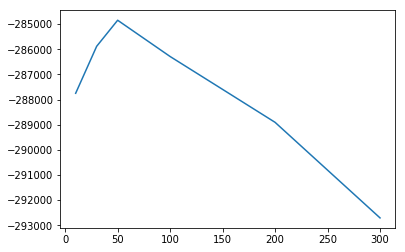

In [7]:
plt.plot(list(TOPIC_NUMS_TUPLE), loglikelihoods)
plt.show()